# Actividad: Clasificación de SPAM

¿Podemos clasificar un email como spam con árboles y/o ensambles?

Usaremos la base de datos [UCI Spam database](https://archive.ics.uci.edu/ml/datasets/Spambase)

Responda las preguntas y realice las actividades en cada uno de los bloques

Entregas al correo phuijse@inf.uach.cl hasta el Viernes 13, 11:20 AM

Se trabajará en grupos de dos personas: se entrega un notebook completo por grupo

# Import libraries

In [1]:
%matplotlib notebook
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import tree, metrics, ensemble
from sklearn.metrics import precision_recall_curve

# Downloading dataset

In [2]:
# Descargar la base de datos con wget, si usas windows usa el link de arriba
!wget -c https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data
!head -n 5 spambase.data

--2019-09-10 10:02:37--  https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data
Resolviendo archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Conectando con archive.ics.uci.edu (archive.ics.uci.edu)[128.195.10.252]:443... conectado.
Petición HTTP enviada, esperando respuesta... 416 Requested Range Not Satisfiable

    El archivo ya se ha obtenido por completo; no hay nada que hacer.

0,0.64,0.64,0,0.32,0,0,0,0,0,0,0.64,0,0,0,0.32,0,1.29,1.93,0,0.96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.778,0,0,3.756,61,278,1
0.21,0.28,0.5,0,0.14,0.28,0.21,0.07,0,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0,1.59,0,0.43,0.43,0,0,0,0,0,0,0,0,0,0,0,0,0.07,0,0,0,0,0,0,0,0,0,0,0,0,0.132,0,0.372,0.18,0.048,5.114,101,1028,1
0.06,0,0.71,0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0,1.16,0.06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.06,0,0,0.12,0,0.06,0.06,0,0,0.01,0.143,0,0.276,0.184,0.01,9.821,485,2259,1
0,0,0,0,0

# Describing Dataset

Responda 
- ¿Cuántos atributos tiene la base de datos? Describalos de forma muy breve
-  Muestre un histograma de las etiquetas ¿Cuántos ejemplos hay de cada clase? ¿Es la base de datos balanceada?
- ¿Hay valores perdidos o invalidas? 

In [3]:
# get data
data = np.genfromtxt('spambase.data', delimiter=',')
X, Y = data[:, :-1], data[:, -1]

data.shape

(4601, 58)

Se tienen 58 atributos, en donde se tienen (descripción de dataset obtenida desde https://archive.ics.uci.edu/ml/datasets):

- 48 atributos que presentan la frecuencia de aparición de ciertas palabras (asociadas a spam, tales como gratis, internet) en cada email.
- 6 atributos que presentan la frecencia de aparición de ciertos caracteres (asociados a spam) en cada email.
- 3 atributos que presentan variables asociadas a la aparición de de caracteres en mayúscula de forma seguida en cada email (esto se asocia a spam).

Las etiquetas son:

- (1) spam
- (0) no spam

<IPython.core.display.Javascript object>


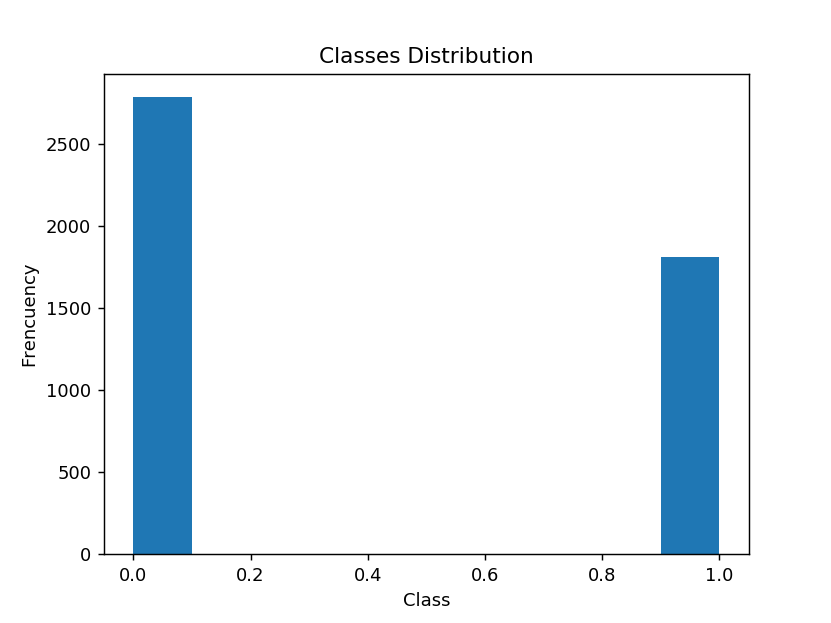

Text(0.5, 1.0, 'Classes Distribution')

In [28]:
# create plot
fig, ax = plt.subplots()

# add data to plot
ax.hist(Y)
ax.set_xlabel("Class")
ax.set_ylabel("Frencuency")
ax.set_title("Classes Distribution")

Se tienen clases desbalanceadas, ya que se tienen 1.000 (aproximadamente) mas instancias de la clase 0 (no spam) que la clase 1.

In [5]:
# Check if data has missing value
display(np.sum(np.isnan(data)))

0

Data no tiene missing values

# Training models

In [6]:
# split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.75, stratify = Y)

Use el conjunto de entrenamiento para entrenar y ajustar los parámetros de un 
1. árbol de decisión
1. ensamble random forest 
1. ensamble *gradient boosting*

Puede usar `GridSearchCV` para encontrar los mejores estimadores

Para este caso particular y para cada estimador responda
- ¿Qué función/criterio funciona mejor? `criterion`
- ¿Qué profundidad de árbol funciona mejor? `max_depth`
- ¿Combiene ponderar las clases? `class_weight`
- En el caso de los ensambles 
    - ¿Es recomendable usar un subconjunto aleatorio de características? `max_features`
    - ¿Cuál es la mejor cantidad de clasificadores débiles? `n_estimators`

Compare los mejores modelos de cada tipo en el conjunto de test usando métricas de clasificación apropiadas

Analice y comente sus resultados

# Decision Tree

### Diseño Experimental:

Se experimenta con los siguientes parámetros:
- Criterion
- Max depth
- Class weight: Se analizan 3 casos: (1) Sin penalización (o igual penalización), (2) Penalización clase 1, (3) Penalización clase 0.

Se utiliza GridSearchCrossValidation, con un K-Fold de 5.

In [19]:
# Define model using gridsearch cross validation

# Define model
dt_model = tree.DecisionTreeClassifier(splitter = 'best')

# Max depths
max_depths = np.linspace(1, 50, 10, dtype = int)

print("depths: ", max_depth)

# without penalization, penalize class 1, penalize class 0
class_weights = [{0:1, 1:1},{0: .2, 1: 0.8}, {0: .8, 1: .2}]

print("class_weights: ", class_weights)

# Parameters of model
# clas_weight: Add penalization to mistakes in minority class (unbalaced classes)
params = {
    "criterion": ("entropy", "gini"),
    "max_depth": max_depth,
    "class_weight":class_weights
}

# Define gridsearch cross validation
gscv_dt = GridSearchCV(dt_model, params, cv = 5)

# train model using grid of parameters
gscv_dt.fit(X_train, Y_train)

# Get best model
best_decision_tree = gscv_dt.best_estimator_

# Display best model
display(best_decision_tree)
# print("Decision tree F1 score: ", metrics.accuracy_score(best_decision_tree.predict(X_test), Y_test))

depths:  [ 1  6 11 17 22 28 33 39 44 50]
class_weights:  [{0: 1, 1: 1}, {0: 0.2, 1: 0.8}, {0: 0.8, 1: 0.2}]


DecisionTreeClassifier(class_weight={0: 0.2, 1: 0.8}, criterion='entropy',
                       max_depth=28, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

### Analisis

- Mejor criterio: Entropia (Mayor ganancia de información por niveles).
- Max_depth: 28. Se observa que las alturas van desde 1 hasta 50, y que el mejor valor es de 28, el que corresponde a una complejidad intermedia del árbol, lo que puede indicar además que si los datos están desbalanceados, puede tener problemas de sobreajuste si el valor fuese mayor.
- Class_weight: Penalización a clase 1. De los 3 casos analizados para class_weight (sin penalización, penalización clase 0 y penalización clase 1), el mejor fue penalizar la clase 1, lo que tiene sentido ya que las clases esta desbalanceadas, teniendo en minoría la clase 1, por lo que al penalizar este clase, la optimización del modelo tenderá a minimizar los errores en este clase.

# Ensemble Random Forest

### Diseño Experimental:

Se experimenta con los siguientes parámetros:
    
- Criterion
- Max depth
- Class weight: Se analizan 3 casos: (1) Sin penalización (o igual penalización), (2) Penalización clase 0, (3) Penalización clase 1.
- Number estimators.
- Max features: Se analizan los casos de (1) sqrt (# features) y (2) log (# features)

Se utiliza GridSearchCrossValidation, con un K-Fold de 5.

In [23]:
# Define model using gridsearch cross validation

# Define model
rf_model = ensemble.RandomForestClassifier(n_jobs=-1)

# criterions
criterions = ("entropy", "gini")
print("criterion: ", criterions)

# Max depths
max_depths = np.linspace(1, 50, 10, dtype = int)
print("depths: ", max_depth)

# without penalization, penalize class 1, penalize class 0
class_weights = [{0:1, 1:1},{0: .2, 1: 0.8}, {0: .8, 1: .2}]
print("class weights :", class_weights)

# number of estimators
n_estimators = np.linspace(1, 100, 10, dtype = int)
print("n° estimators: ", n_estimators)

# max features
max_features = ["sqrt", "log2"]
print("max features: ", max_features)

# Parameters of model
# clas_weight: Add penalization to mistakes in minority class (unbalaced classes)
params = {
    "criterion": criterions,  
    "max_depth": max_dephts,
    "class_weight": class_weights,
    "n_estimators": n_estimators,
    "max_features": max_features
}

# Define gridsearch cross validation
gscv_rf = GridSearchCV(rf_model, params, cv = 5)

# train model using grid of parameters
gscv_rf.fit(X_train, Y_train)

# Get best model
best_random_forest = gscv_rf.best_estimator_

# Display best model
display(best_random_forest)
# print("Decision tree F1 score: ", metrics.accuracy_score(best_random_forest.predict(X_test), Y_test))

criterion:  ('entropy', 'gini')
depths:  [ 1  6 11 17 22 28 33 39 44 50]
class weights : [{0: 1, 1: 1}, {0: 0.2, 1: 0.8}, {0: 0.8, 1: 0.2}]
n° estimators:  [  1  12  23  34  45  56  67  78  89 100]
max features:  ['sqrt', 'log2']


RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 1},
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=45, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

### Analisis

- Criterion: Gini.
- Max depth: 10. Cabe destacar que es un valor bajo respecto a los posibles valores (desde 1 hasta 50), lo que no es esperable, ya que en teoría, random forest obtiene mejores resultados con árboles inestables (con alta profunidad). Esto puede deberse a que usa criterio gini para el cálculo de las ganancias donde el cálculo de la impureza con bajos valores de profundidad limitaría la complejidad, ya que aumentando la cantidad de profundidades, éste valor de profundidad aumenta además del criterio a usar en la obtención de ganancias, donde si se calcula las ganancias con entropía y altos valores de profundidad, la complejidad del árbol es más efectiva para random forest.
- Class weight: En este caso (a diferencia de Desicion Tree), el mejor resultado se obtiene sin penalización, por lo que al parecer este algoritmo no es sensible al grado de desbalance de clases de este conjunto de datos.
- Number estimators: 45. Corresponde a un valor medio del rango analizado (desde 1 hasta 100), podemos basarnos en al análisis obtenido por la profundidad, donde la falta de complejidad del árbol límite la cantidad de split a utilizar.
- Max features: Sqrt, el cual es esperable, ya que en la práctica esta es la mejor opción, donde los valores categóricos deben ser un poco más altos para compensar el sobreajuste del arbol por cada split. 

# Gradient Boosting Ensemble

### Diseño Experimental:

Se experimenta con los siguientes parámetros:
    
- Criterion.
- Max depth.
- Number estimators.
- Max features: Se analizan los casos de (1) sqrt (# features) y (2) log (# features)

Se utiliza GridSearchCrossValidation, con un K-Fold de 5.

In [25]:
# Define model using gridsearch cross validation

# Define model
gb_model = ensemble.GradientBoostingClassifier(subsample=0.5, 
                                               learning_rate=0.1)
# criterions
criterions = ("friedman_mse", "mse")
print("criterion: ", criterions)

# Max depths
max_depths = np.linspace(1, 50, 10, dtype = int)
print("depths: ", max_depth)

# number of estimators
n_estimators = np.linspace(1, 100, 10, dtype = int)
print("n° estimators: ", n_estimators)

# max features
max_features = ["sqrt", "log2", None]
print("max features: ", max_features)

# Parameters of model
# clas_weight: Add penalization to mistakes in minority class (unbalaced classes)
params = {
    "criterion": criterions,  
    "max_depth": max_depths,
    "n_estimators": n_estimators,
    "max_features": max_features
}

# Define gridsearch cross validation
gscv_gb = GridSearchCV(gb_model, params, cv = 5)

# train model using grid of parameters
gscv_gb.fit(X_train, Y_train)

# Get best model
best_gradient_boosting = gscv_gb.best_estimator_

# Display best model
display(best_gradient_boosting)
# print("Decision tree F1 score: ", metrics.accuracy_score(best_gradient_boosting.predict(X_test), Y_test))

criterion:  ('friedman_mse', 'mse')
depths:  [ 1  6 11 17 22 28 33 39 44 50]
n° estimators:  [  1  12  23  34  45  56  67  78  89 100]
max features:  ['sqrt', 'log2', None]


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=11,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### Analisis

- Criterion: Friedman_mse.
- Max depth: 11. Cabe destacar que corresponde a un valor bajo respecto a los valores analizados. Esto es esperable ya que el algoritmo gradient boosting obtiene mejores resultados utilizando clasificadores debiles estables, lo que para el caso de decision trees, estos corresponden a arboles con poca profunidad.
- Number estimators: 100. Cabe destacar que se obtuvo el mayor número de estimadores, que dependerá que tan simple son los árboles y de la función de pérdida usada para el cálculo de los residuos donde necesitará mayor o menor cantidad de árboles a analizar
- Max features: Log2. Cabe destacar que se utiliza también valor None, el cual no realiza split de las features, por lo que este algoritmo se beneficia si es que se hace muestreo sobre las features.

<b> Nota importante </b>

Cabe destacar que el tiempo de ejecución de este experimento fue considerablemente mayor que los anteriores (Decision Tree y Random Forest tomaron 10 [min] aproximadamente, sin embargo Gradient Boostin tomó cerca de 30 [min]). Esto es esperable ya que el algoritmo entrena los clasificadores de forma secuencial, por lo que no se puede paralelizar los entrenamientos de los diferentes algoritmos (a diferencia de Random Forest, el cual es un ensamble paralelo).

# Evaluating and comparing models

### Diseño

Debido a que clases estan desbalanceadas, se analizan los resultados considerando una curva Precision vs Recall (ROC no es recomendable para clases desbalanceadas). Luego, para cada modelo, se obtiene la curva y valor AUC.

<IPython.core.display.Javascript object>


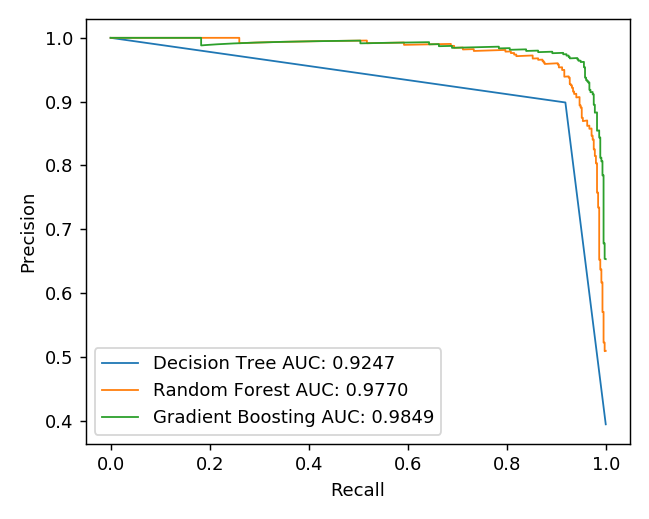

In [29]:
# Get plot
fig, ax = plt.subplots(1, figsize=(5, 4), tight_layout=True)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

# get Gridsearch of each model
models_gscv = [gscv_dt, gscv_rf, gscv_gb]
names = ["Decision Tree", "Random Forest", "Gradient Boosting"]

# Iterate over each model
for name, gscv in zip(names, models_gscv):
    
    # get predictio of each best model
    Y_pred = gscv.best_estimator_.predict_proba(X_test)[:, 1]

    # Get get precision-recall for each model
    precision, recall, th = precision_recall_curve(Y_test, Y_pred)
    
    # create lable name
    label = name + ' AUC: ' + ("%.4f" %  metrics.auc(recall, precision))
    
    #plot recall precision curve
    ax.plot(recall, precision, label = label, linewidth=1)

# Add label
plt.legend(loc=3);

### Analisis



Los valores de AUC ordenados de forma descendente corresponden a:
1. Gradient Boosting: 0.9849
2. Random Forest: 0.9770
3. Decision Tree: 0.9247

De estos resultados, Gradient Boosting obtiene el mejor rendimiento comparado con los otros algoritmos. Sin embargo, el tiempo de entrenamiento es mayor para este algoritmo, comparado con Random Forest y Decision Tree. Esto se debe al entrenamiento secuencial de los clasificadores débiles para el caso de Gradient Boosting (RF es entrenamiento paralelo y Decision Tree es un solo modelo).

Cabe destacar además que ambos ensambles obtuvieron mayor rendimiento que decision tree, lo  que significa que en este caso, el ensamble de clasificadores débiles obtiene mejor rendimiento sobre clasificación que un clasificador débil, por lo que utilizar ensamble de clasificadores en esta tarea específica es mejor que utilizar clasificador débil solo.